
# ✈️ AeroConnect Route Analytics & Forecasting

**Author:** Keshav Goel

This notebook explores international route performance for AeroConnect and builds a short-term passenger forecast for selected routes.

## Objectives
1. **Understand the data**
   - Identify highest and lowest trafficked routes
   - Analyze trends and geographical patterns (ports, countries, seasonality)
2. **Build models**
   - Compare classic models (Linear Regression, Ridge, Lasso, Random Forest, Gradient Boosting)
   - Forecast passenger traffic for the next 6–12 months on at least one city pair
3. **Evaluate & recommend**
   - Explain model choices and report accuracy
   - Provide route/network recommendations and how to use the model going forward


## 0) Pip Installs

In [1]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


## 1) Imports & Configuration

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## 2) Load Data

In [3]:
df = pd.read_csv('csv.csv')
df.head()


,Month,AustralianPort,ForeignPort,Country,Passengers_In,Freight_In_(tonnes),Mail_In_(tonnes),Passengers_Out,Freight_Out_(tonnes),Mail_Out_(tonnes),Passengers_Total,Freight_Total_(tonnes),Mail_Total_(tonnes),Year,Month_num
0,Jan-85,Adelaide,Auckland,New Zealand,1513,42.167,0.311,985,18.704,0.924,2498,60.871,1.235,1985,1
1,Jan-85,Adelaide,Bahrain,Bahrain,12,0.000,0.000,5,0.033,0.000,17,0.033,0.000,1985,1
2,Jan-85,Adelaide,Bombay,India,7,0.000,0.000,5,0.000,0.000,12,0.000,0.000,1985,1
3,Jan-85,Adelaide,Frankfurt,Germany,115,0.009,0.000,171,0.000,0.248,286,0.009,0.248,1985,1
4,Jan-85,Adelaide,London,UK,1567,2.800,0.000,1472,10.618,2.487,3039,13.418,2.487,1985,1


## 3) Initial Inspection

In [4]:
#Checking if any data is repeated and for the general summary stats of the data
print("Duplicates:", df.duplicated().sum())
df.describe()


Duplicates: 0


,Passengers_In,Freight_In_(tonnes),Mail_In_(tonnes),Passengers_Out,Freight_Out_(tonnes),Mail_Out_(tonnes),Passengers_Total,Freight_Total_(tonnes),Mail_Total_(tonnes),Year,Month_num
count,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000
mean,1489.993499,57.578618,1.326173,1439.835784,66.320506,2.065110,2929.829283,123.899124,3.391284,1986.862086,6.199620
std,3101.650858,150.503467,5.735984,3065.381839,165.840735,6.493602,6130.619566,297.553857,10.399799,1.300700,3.442343
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1985.000000,1.000000
25%,45.000000,0.000000,0.000000,51.000000,0.000000,0.000000,100.000000,0.050000,0.000000,1986.000000,3.000000
50%,333.000000,2.117000,0.000000,324.000000,5.200000,0.007000,664.000000,13.100000,0.041000,1987.000000,6.000000
75%,1586.000000,41.666000,0.224500,1535.500000,58.666000,1.061500,3131.500000,93.722500,1.517500,1988.000000,9.000000
max,37754.000000,1795.482000,110.518000,38475.000000,1899.032000,103.111000,70014.000000,3242.982000,197.697000,1989.000000,12.000000


In [5]:
#From this we can see that there are no nan values and the general data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Month                   9999 non-null   object 
 1   AustralianPort          9999 non-null   object 
 2   ForeignPort             9999 non-null   object 
 3   Country                 9999 non-null   object 
 4   Passengers_In           9999 non-null   int64  
 5   Freight_In_(tonnes)     9999 non-null   float64
 6   Mail_In_(tonnes)        9999 non-null   float64
 7   Passengers_Out          9999 non-null   int64  
 8   Freight_Out_(tonnes)    9999 non-null   float64
 9   Mail_Out_(tonnes)       9999 non-null   float64
 10  Passengers_Total        9999 non-null   int64  
 11  Freight_Total_(tonnes)  9999 non-null   float64
 12  Mail_Total_(tonnes)     9999 non-null   float64
 13  Year                    9999 non-null   int64  
 14  Month_num               9999 non-null   

## 4) Cleaning & Feature Engineering

In [6]:
# Route column to make it easier to visualize the to-and-from
df_new = df.copy()

df_new['route'] = df_new['AustralianPort'].str.strip().str.title() + ' - ' + df_new['ForeignPort'].str.strip().str.title()

# Standardize text columns by removing any trailing spaces and capitalizing
for col in ['AustralianPort','ForeignPort','Country']:
    df_new[col] = df_new[col].astype(str).str.strip().str.title()

# Create date field as a datetime format to make it easier for mdodel
df_new['date'] = pd.to_datetime(df_new['Year'].astype(str) + '-' + df_new['Month_num'].astype(str), format='%Y-%m')

df_new.drop('Month',axis =1,inplace= True)

In [7]:
#Reorder Dataframe
df_new = df_new[['date','Year','Month_num','route','AustralianPort','ForeignPort','Country','Passengers_In','Passengers_Out','Passengers_Total','Freight_In_(tonnes)','Freight_Out_(tonnes)','Freight_Total_(tonnes)','Mail_In_(tonnes)','Mail_Out_(tonnes)', 'Mail_Total_(tonnes)']]

In [8]:
#Checking head to make sure it all looks good
df_new.head(5)

,date,Year,Month_num,route,AustralianPort,ForeignPort,Country,Passengers_In,Passengers_Out,Passengers_Total,Freight_In_(tonnes),Freight_Out_(tonnes),Freight_Total_(tonnes),Mail_In_(tonnes),Mail_Out_(tonnes),Mail_Total_(tonnes)
0,1985-01-01,1985,1,Adelaide - Auckland,Adelaide,Auckland,New Zealand,1513,985,2498,42.167,18.704,60.871,0.311,0.924,1.235
1,1985-01-01,1985,1,Adelaide - Bahrain,Adelaide,Bahrain,Bahrain,12,5,17,0.000,0.033,0.033,0.000,0.000,0.000
2,1985-01-01,1985,1,Adelaide - Bombay,Adelaide,Bombay,India,7,5,12,0.000,0.000,0.000,0.000,0.000,0.000
3,1985-01-01,1985,1,Adelaide - Frankfurt,Adelaide,Frankfurt,Germany,115,171,286,0.009,0.000,0.009,0.000,0.248,0.248
4,1985-01-01,1985,1,Adelaide - London,Adelaide,London,Uk,1567,1472,3039,2.800,10.618,13.418,0.000,2.487,2.487


# Task 1: Understanding the data
## 1a) Identifying the most and least trafficked routes

Top 10 Routes:
 route
Sydney - Auckland        2961212
Sydney - Singapore       1440018
Sydney - Tokyo           1292116
Sydney - Hong Kong       1151900
Perth - Singapore         952926
Brisbane - Auckland       893246
Sydney - Christchurch     882357
Melbourne - Singapore     865251
Sydney - Los Angeles      862964
Sydney - Honolulu         861814
Name: Passengers_Total, dtype: int64


/var/folders/bb/hsp4zv4n1j90qvy7v635c_m40000gn/T/ipykernel_90521/3967396550.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_routes.values, y=top_routes.index, palette='deep')


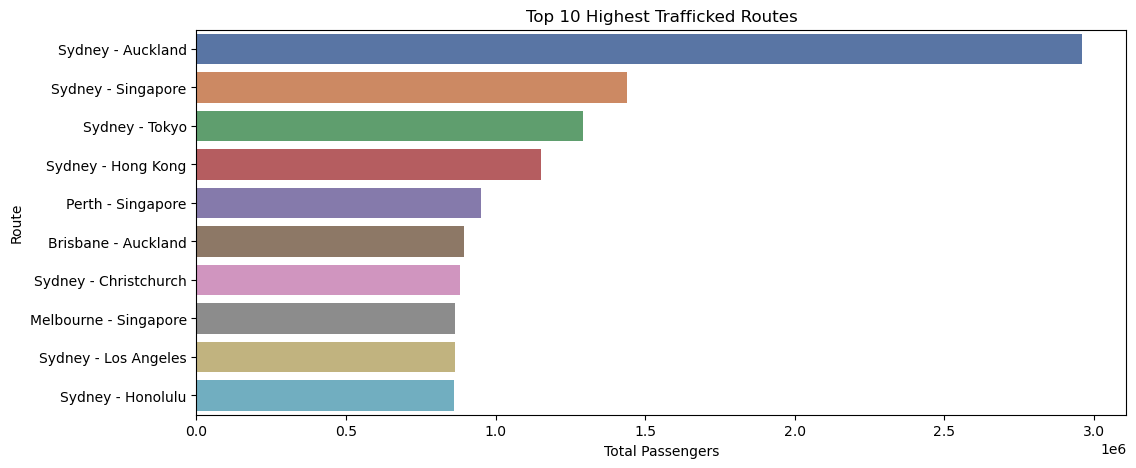

<Figure size 640x480 with 0 Axes>

In [9]:
#Creating an aggregated df to see the total passengers by route
route_traffic = df_new.groupby('route')['Passengers_Total'].sum().sort_values(ascending=False)

# Top 10 routes
top_routes = route_traffic.head(10)

print("Top 10 Routes:\n", top_routes)

# Plotting
plt.figure(figsize=(12,5))
sns.barplot(x=top_routes.values, y=top_routes.index, palette='deep')
plt.title("Top 10 Highest Trafficked Routes")
plt.xlabel("Total Passengers")
plt.ylabel("Route")
plt.show()

plt.savefig("Visualizations/top_10_traffic.png")


Bottom 10 Routes with 0:
 route
Hobart - Los Angeles           2
Hobart - Tokyo                 1
Cairns - Honiara               1
Townsville - San Francisco     1
Darwin - Zagreb                1
Melbourne - Denver             0
Perth - Bandar Seri Begawan    0
Brisbane - Colombo             0
Adelaide - Harare              0
Brisbane - Chicago             0
Name: Passengers_Total, dtype: int64

Bottom 10 Routes, no 0:
 route
Darwin - Zagreb               1
Hobart - Tokyo                1
Townsville - San Francisco    1
Cairns - Honiara              1
Hobart - Los Angeles          2
Perth - Port Moresby          2
Adelaide - Jakarta            3
Hobart - Denpasar             3
Cairns - Belgrade             3
Cairns - Larnaca              4
Name: Passengers_Total, dtype: int64


/var/folders/bb/hsp4zv4n1j90qvy7v635c_m40000gn/T/ipykernel_90521/1145131071.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bottom_routes_filtered.values, y=bottom_routes_filtered.index, palette='deep')


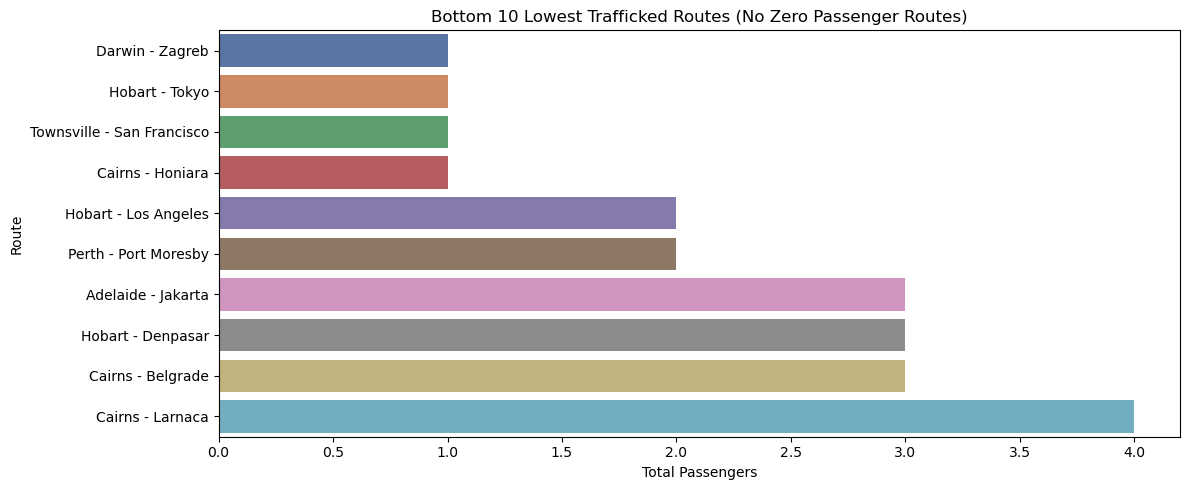

<Figure size 640x480 with 0 Axes>

In [10]:
# Comparing both 0 routes and non-0 routes to allow for greater analysis
nonzero_route_traffic = route_traffic[route_traffic > 0]
bottom_routes_filtered = nonzero_route_traffic.sort_values().head(10)

print("Bottom 10 Routes with 0:\n", route_traffic.tail(10))
print()
print("Bottom 10 Routes, no 0:\n", bottom_routes_filtered)

# Plot bottom 10 non-zero routes
plt.figure(figsize=(12, 5))
sns.barplot(x=bottom_routes_filtered.values, y=bottom_routes_filtered.index, palette='deep')
plt.title("Bottom 10 Lowest Trafficked Routes (No Zero Passenger Routes)")
plt.xlabel("Total Passengers")
plt.ylabel("Route")
plt.tight_layout()
plt.show()

plt.savefig("Visualizations/bottom_10_traffic.png")

## Task 1b/c: Analyze trends and Visualize them

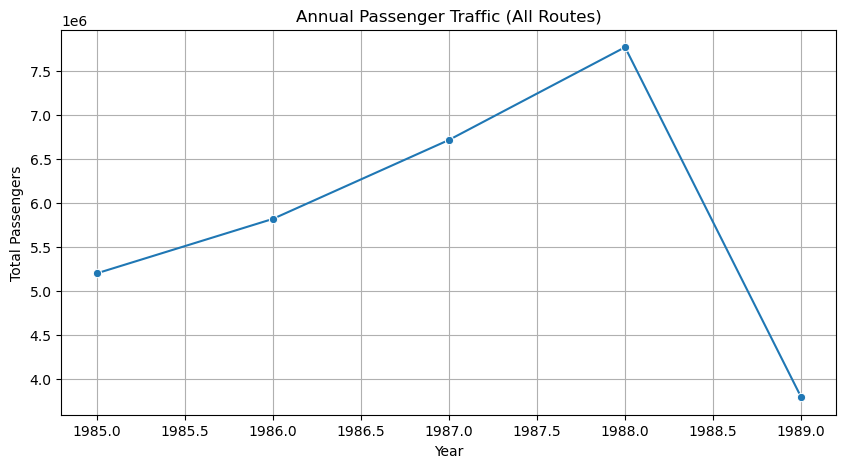

<Figure size 640x480 with 0 Axes>

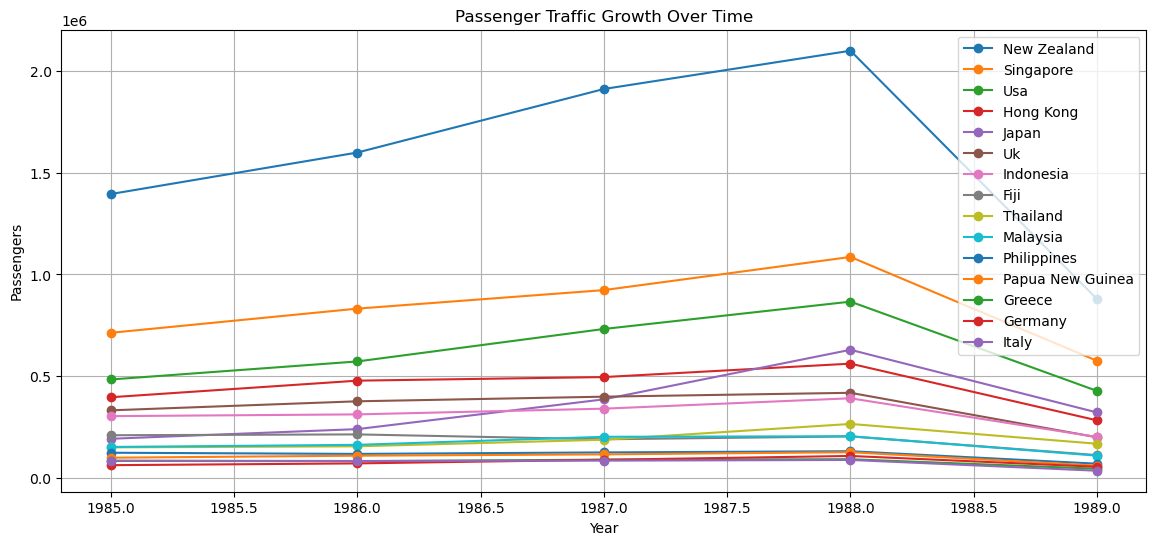

<Figure size 640x480 with 0 Axes>

In [11]:
#Line plot to show both the overall passengers and Individual Country Passengers

#Aggregated by year to show overall
annual_traffic = df_new.groupby('Year')['Passengers_Total'].sum()

plt.figure(figsize=(10,5))
sns.lineplot(x=annual_traffic.index, y=annual_traffic.values, marker='o')
plt.title("Annual Passenger Traffic (All Routes)")
plt.ylabel("Total Passengers")
plt.xlabel("Year")
plt.grid(True)
plt.show()

plt.savefig("Visualizations/total_annual_traffic.png")


#Aggregated dfs for each individual country and relative year
country_year = df_new.groupby(['Year','Country'])['Passengers_Total'].sum().reset_index()
country_traffic = df_new.groupby('Country')['Passengers_Total'].sum().sort_values(ascending=False).head(15)

plt.figure(figsize=(14,6))

#Getting all the aggregated passenger data for each country and appending it to the plot
top_countries = country_traffic.index
for c in country_traffic.index:
    subset = country_year[country_year['Country'] == c]
    plt.plot(subset['Year'], subset['Passengers_Total'], marker='o', label=c)

plt.title("Passenger Traffic Growth Over Time")
plt.xlabel("Year")
plt.ylabel("Passengers")
plt.legend()
plt.grid(True)
plt.show()

plt.savefig("Visualizations/traffic_over_time.png")


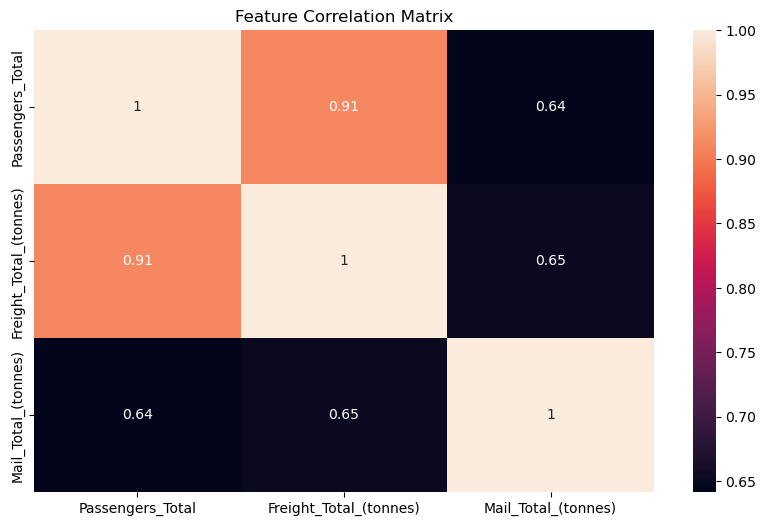

<Figure size 640x480 with 0 Axes>

In [12]:
#Simple Heatmap to see some correlations between features

plt.figure(figsize=(10, 6))
sns.heatmap(df_new[['Passengers_Total', 'Freight_Total_(tonnes)', 'Mail_Total_(tonnes)']].corr(), annot=True)
plt.title("Feature Correlation Matrix")
plt.show()

plt.savefig("Visualizations/heatmap.png")


/var/folders/bb/hsp4zv4n1j90qvy7v635c_m40000gn/T/ipykernel_90521/3057426856.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=country_freight.values, y=country_freight.index, palette="deep")


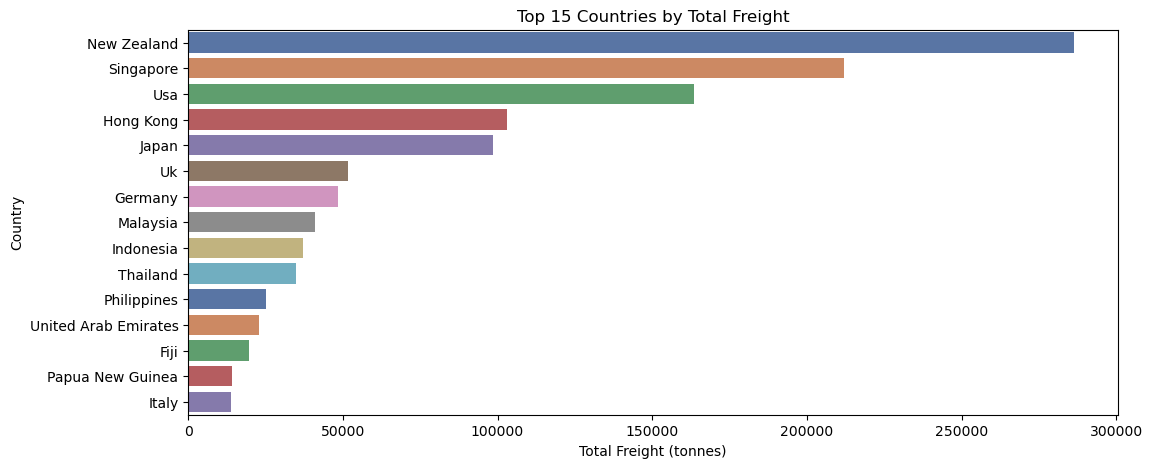

<Figure size 640x480 with 0 Axes>

In [13]:
#Visualizing which countries have the most freight
#Aggregated by Country and total freight
country_freight = df_new.groupby('Country')['Freight_Total_(tonnes)'].sum().sort_values(ascending=False).head(15)

plt.figure(figsize=(12,5))
sns.barplot(x=country_freight.values, y=country_freight.index, palette="deep")
plt.title("Top 15 Countries by Total Freight")
plt.xlabel("Total Freight (tonnes)")
plt.ylabel("Country")
plt.show()

plt.savefig("Visualizations/top_15_freight.png")


/var/folders/bb/hsp4zv4n1j90qvy7v635c_m40000gn/T/ipykernel_90521/2104248069.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=country_mail.values, y=country_mail.index, palette="deep")


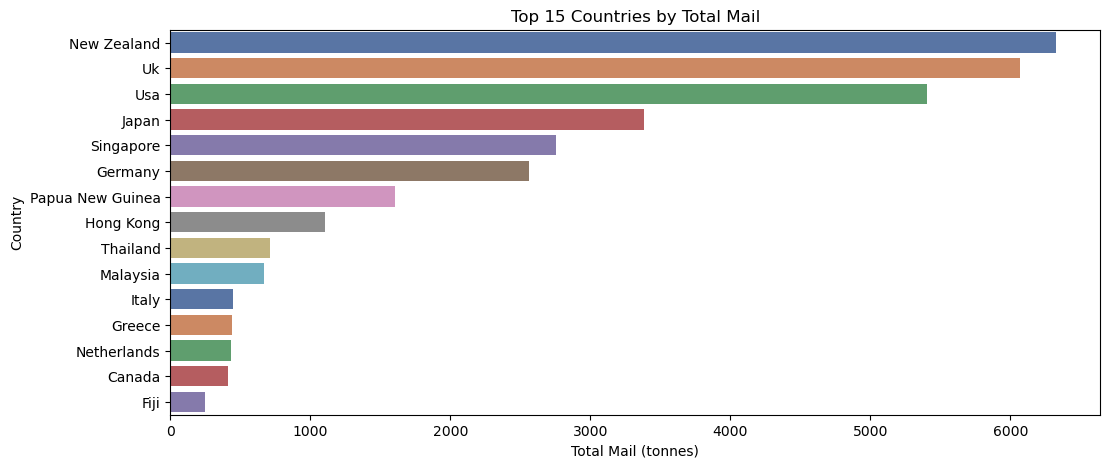

<Figure size 640x480 with 0 Axes>

In [14]:
#Which countries have the most mail
#Aggregated by country and total mail sum
country_mail = df_new.groupby('Country')['Mail_Total_(tonnes)'].sum().sort_values(ascending=False).head(15)

plt.figure(figsize=(12,5))
sns.barplot(x=country_mail.values, y=country_mail.index, palette="deep")
plt.title("Top 15 Countries by Total Mail")
plt.xlabel("Total Mail (tonnes)")
plt.ylabel("Country")
plt.show()

plt.savefig("Visualizations/top_15_mail.png")


/var/folders/bb/hsp4zv4n1j90qvy7v635c_m40000gn/T/ipykernel_90521/1651573183.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ratio.values, y=ratio.index, palette="deep")


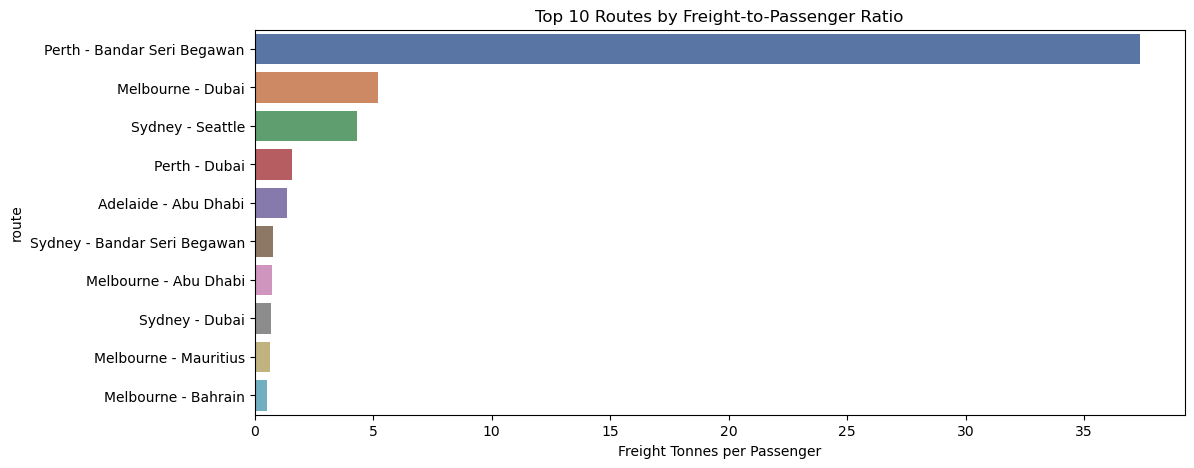

<Figure size 640x480 with 0 Axes>

In [15]:
# Freight to Passenger Ratio
# Higher means more freight compared to passengers 

#Creating new column for ratio and then aggregating by route and ratio, this is to see which route is mainly for industrial purposes
df_new['Freight_per_Passenger'] = df_new['Freight_Total_(tonnes)'] / (df_new['Passengers_Total']+1)  
ratio = df_new.groupby('route')['Freight_per_Passenger'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(12,5))
sns.barplot(x=ratio.values, y=ratio.index, palette="deep")
plt.title("Top 10 Routes by Freight-to-Passenger Ratio")
plt.xlabel("Freight Tonnes per Passenger")
plt.show()

plt.savefig("Visualizations/top_10_ftp.png")


# Task 2
## 2a) Building and using the model

In [16]:
# Since we already know Sydney-Auckland is #1 we can just call all the values related to
# that route, and then sort by date to be in chronological order which is important for Prophet
top_route = df_new[df_new['route']=='Sydney - Auckland']
route_df = top_route.sort_values('date')

#Next we intialize a Prophet dataframe since the model looks for certain key column names like ds/datestamp and our target y
df_prophet = route_df[['date', 'Passengers_Total']].rename(columns={'date': 'ds', 'Passengers_Total': 'y'})

# We choose yearly seasonality since travel is seasonal and varies based on things like holidays
# It also allows for the model to learn from seasonal spikes
model = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=False)
model.fit(df_prophet)

04:28:34 - cmdstanpy - INFO - Chain [1] start processing
04:28:34 - cmdstanpy - INFO - Chain [1] done processing


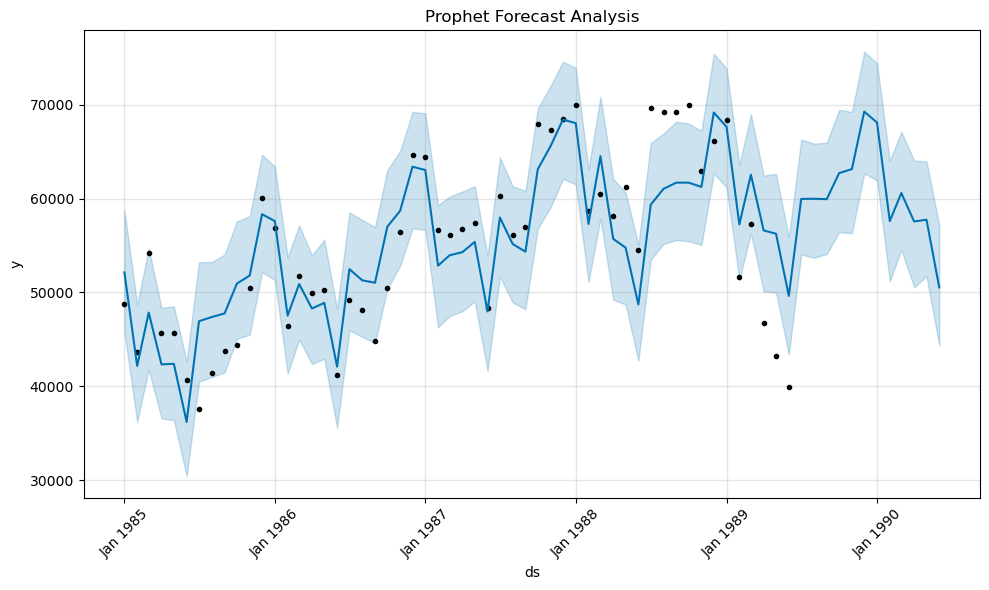

<Figure size 640x480 with 0 Axes>

In [17]:
#Make our predictions and then plot them to see accuracy
future = model.make_future_dataframe(periods=12, freq='MS')
forecast = model.predict(future)


#Convert the X-axis into an easier to read DateTime format
fig = model.plot(forecast)

ax = fig.gca()

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.set_title("Prophet Forecast Analysis")

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

plt.savefig("Visualizations/prophet_forecast_plot.png")


#The solid line represents prophets forecast, dots represent actual data, shaded represents uncertainty interval

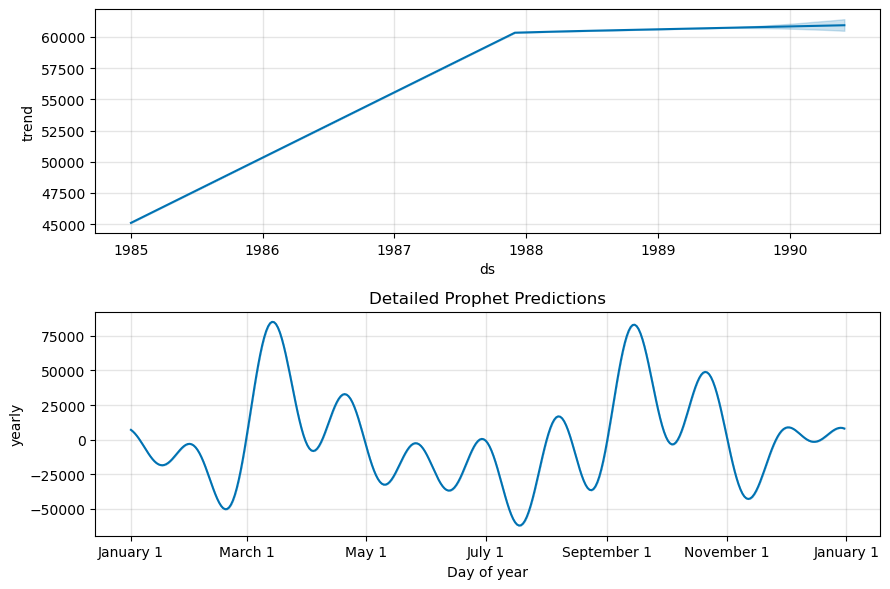

<Figure size 640x480 with 0 Axes>

In [18]:
#A more in depth look on Prophet's predictions
fig = model.plot_components(forecast)
ax = fig.gca()
ax.set_title('Detailed Prophet Predictions')

plt.tight_layout()
plt.show()

plt.savefig("Visualizations/top_prophet_pred.png")


In [19]:
# Printing the 12 month forecast that prophet made
print("12 month forecast:\n", forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12))

12 month forecast:
            ds          yhat    yhat_lower    yhat_upper
54 1989-07-01  59969.993910  54048.873181  66311.915007
55 1989-08-01  59993.330106  53714.349910  65865.395123
56 1989-09-01  59950.005006  54095.453263  65972.865232
57 1989-10-01  62723.166182  56423.648748  69474.783240
58 1989-11-01  63156.531603  56323.169619  69253.172335
59 1989-12-01  69281.568040  62682.835507  75687.565242
60 1990-01-01  68123.374753  61963.695099  74449.907717
61 1990-02-01  57616.887483  51181.319888  64039.148674
62 1990-03-01  60602.485929  54547.848083  67143.820195
63 1990-04-01  57570.378414  50567.439720  64069.552695
64 1990-05-01  57758.644120  51721.597380  63975.499178
65 1990-06-01  50542.184284  44343.558594  57167.087113


# Task 3
## 3b) Evaluating Performance

In [20]:
#Creating a dataframe to get the overall performance of our model
confirmation_df = forecast.set_index('ds')[['yhat']].join(df_prophet.set_index('ds').y).reset_index(drop = True)
confirmation_df.dropna(inplace=True)
confirmation_df.tail()

,yhat,y
49,57256.467416,51697.0
50,62559.281897,57288.0
51,56616.540680,46747.0
52,56265.110301,43203.0
53,49641.468200,39950.0


In [21]:
# using scikit to get the overall performance and accuracy
print('r2:', r2_score(confirmation_df.y, confirmation_df.yhat))
print('mse:', mean_squared_error(confirmation_df.y, confirmation_df.yhat))
print('mae:', mean_absolute_error(confirmation_df.y, confirmation_df.yhat))

r2: 0.7174804425286274
mse: 24071540.466327913
mae: 3892.2428404301795


## More in depth explorations of the tasks shall be in the pdf attached to the read me and repo :) 

In [22]:
#df_new.to_csv("cleaned_dataframe.csv")